Epoch [1/10], Train Loss: 0.6580, Val Loss: 0.3766
Epoch [2/10], Train Loss: 0.4252, Val Loss: 0.3755
Epoch [3/10], Train Loss: 0.4018, Val Loss: 0.3598
Epoch [4/10], Train Loss: 0.3723, Val Loss: 0.3542
Epoch [5/10], Train Loss: 0.3397, Val Loss: 0.3329
Epoch [6/10], Train Loss: 0.3482, Val Loss: 0.4344
Epoch [7/10], Train Loss: 0.3195, Val Loss: 0.3466
Epoch [8/10], Train Loss: 0.3050, Val Loss: 0.4227
Epoch [9/10], Train Loss: 0.2860, Val Loss: 0.3638
Epoch [10/10], Train Loss: 0.2617, Val Loss: 0.4153
              precision    recall  f1-score     support
Benign         0.946429  0.861789  0.902128  246.000000
Malignant      0.604651  0.812500  0.693333   64.000000
accuracy       0.851613  0.851613  0.851613    0.851613
macro avg      0.775540  0.837144  0.797730  310.000000
weighted avg   0.875868  0.851613  0.859022  310.000000


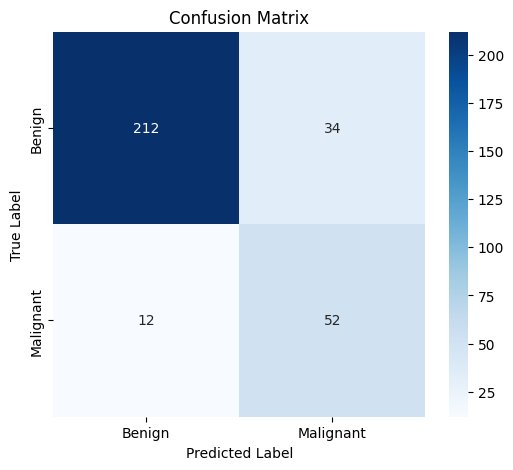

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from medmnist import NoduleMNIST3D
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom transformation for 3D images
def transform_3d(img):
    img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
    img = img.unsqueeze(0)  # Add channel dimension (C, D, H, W)
    return img

# Load NoduleMNIST3D dataset
train_dataset = NoduleMNIST3D(split="train", transform=transform_3d, download=True)
val_dataset = NoduleMNIST3D(split="val", transform=transform_3d, download=True)
test_dataset = NoduleMNIST3D(split="test", transform=transform_3d, download=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple 3D CNN Model
class ResNet3D(nn.Module):
    def __init__(self):
        super(ResNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)

        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)

        self.fc1 = nn.Linear(256 * 3 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary classification (benign vs malignant)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = ResNet3D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32).squeeze(1), labels.to(device, dtype=torch.long).squeeze()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32).squeeze(1), labels.to(device, dtype=torch.long).squeeze()
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# Train the model
num_epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32).squeeze(1), labels.to(device, dtype=torch.long).squeeze()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Benign", "Malignant"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
